In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from unityagents import UnityEnvironment

from a2c_agent import A2CAgent
from config import Config

%matplotlib inline

# Report for the A2C Algorithm
First load the Config class to initiate the unity environment

In [2]:
config = Config()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [10]:
def print_env_information(config):
    config.env_info = config.env.reset(train_mode=False)[config.brain_name]
    config.num_agents = len(config.env_info.agents)
    print('Number of agents:', config.num_agents)
    print('Size of each action:', config.action_dim)
    config.states = config.env_info.vector_observations
    print('There are {} agents. Each observes a state with length: {}'.format(config.states.shape[0], config.state_dim))
    print('The state for the first agent looks like:', config.states[0])

def run_random_env(config):
    env_info = config.env.reset(train_mode=False)[config.brain_name]
    states = env_info.vector_observations
    scores = np.zeros(config.num_agents)
    steps = 500
    for t in range(steps):
        actions = np.random.randn(config.num_agents, config.action_dim)
        actions = np.clip(actions, -1, 1)
        env_info = config.env.step(actions)[config.brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += env_info.rewards
        states = next_states
        if np.any(dones):
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

## System information and random run
The environment state is a vector of 33 inputs for each robot arm. 20 robots are setup for the environment. Actions for each robot arm are a vector of 4 continuous actions in the interval [-1,1].

In [11]:
print_env_information(config)

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.25389481e+00 -1.00000000e+00
  7.30836487e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  1.23100638e-01]


Now let's take 50 random stept for each arm

In [13]:
run_random_env(config)

Total score (averaged over agents) this episode: 0.06099999863654375


## A2C Agent
In the a2c_agent.py and the a2c_model.py is the setup for the A2C algorithm. You can train your own agent and save the weights when you run the run_a2c.py.
The small run script trains the agent and saves the weights every 50 episodes and the final weights. Also the score is saved in a numpy file. In the following I will load the saved weights and scores to show the performance

In [6]:
agent = A2CAgent(config)
agent.load_checkpoint('weights/a2c_simple/cp-0176.pt')

In [8]:
def run_agent_env(config):
    env_info = config.env.reset(train_mode=False)[config.brain_name]
    states = env_info.vector_observations
    scores = np.zeros(config.num_agents)
    steps = 1000
    for t in range(steps):
        states = torch.tensor(states, dtype=torch.float, device=agent.network.device)
        predictions = agent.act(states)
#         actions = np.clip(actions, -1, 1)
        env_info = config.env.step(predictions['actions'].detach()
                                   .cpu().numpy())[config.brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += env_info.rewards
        states = next_states
        if np.any(dones):
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [14]:
run_agent_env(config)

Total score (averaged over agents) this episode: 35.54599920548499


In [17]:
config.env.close()

Now let's check how the mean score evolved during training

In [33]:
scores = np.load('weights/a2c_simple/a2c_simple_final.npy')
means = np.mean(scores, axis=2)

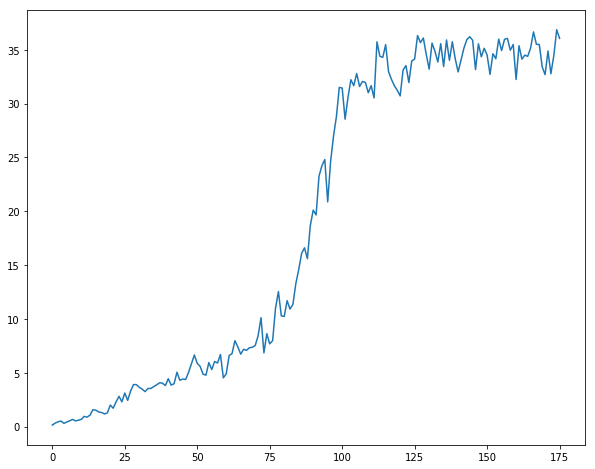

In [41]:
x = np.arange(176)
fig, axs = plt.subplots(1, 1, figsize=(10,8))

axs1 = plt.plot(x, means)